# Problem Description

## Context
The bank has a growing customer base. The bank wants to increase borrowers (asset
customers) base to bring in more loan business and earn more through the interest on
loans. So , the bank wants to convert the liability based customers to personal loan
customers. (while retaining them as depositors). A campaign that the bank ran last year
for liability customers showed a healthy conversion rate of over 9% success. The
department wants you to build a model that will help them identify the potential
customers who have a higher probability of purchasing the loan. This will increase the
success ratio while at the same time reduce the cost of the campaign.

## Objective
The classification goal is to predict the likelihood of a liability customer buying personal
loans.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
       
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\Users\Public\Ananconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_excel('dataset.xlsx', sheet_name = 'Data')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# Creating a copy for EDA
df_bank = df

In [4]:
y = df_bank['Personal Loan']                                # Adjusting the position of column Personal Loan.
df_bank.drop(['Personal Loan'], axis = 1,inplace = True)
df['Personal Loan'] = y
df_bank.head(2)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,1,25,1,49,91107,4,1.6,1,0,1,0,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,1,0,0,0,0


### Data Cleaning

In [5]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
 13  Personal Loan       5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [6]:
df.isnull().any()

ID                    False
Age                   False
Experience            False
Income                False
ZIP Code              False
Family                False
CCAvg                 False
Education             False
Mortgage              False
Securities Account    False
CD Account            False
Online                False
CreditCard            False
Personal Loan         False
dtype: bool

In [7]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.104400,0.06040,0.596800,0.294000,0.096000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.305809,0.23825,0.490589,0.455637,0.294621
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.00000,1.000000,1.000000,0.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.00000,1.000000,1.000000,1.000000


> *Experience* can not have negative values.

In [8]:
df_bank[df_bank['Experience'] < 0].Experience.count()

52

- There are 52 total negative values in the *Experience* column.
- We have to impute the negative values with the median.

In [9]:
median = df_bank.Experience.median()
df_bank['Experience'].replace([-1, -2, -3], value = median, inplace = True)

- Let's see if the *Experience* column still contains negative values.

In [10]:
df_bank[df_bank['Experience'] < 0].Experience.count()

0

<Figure size 576x1440 with 0 Axes>

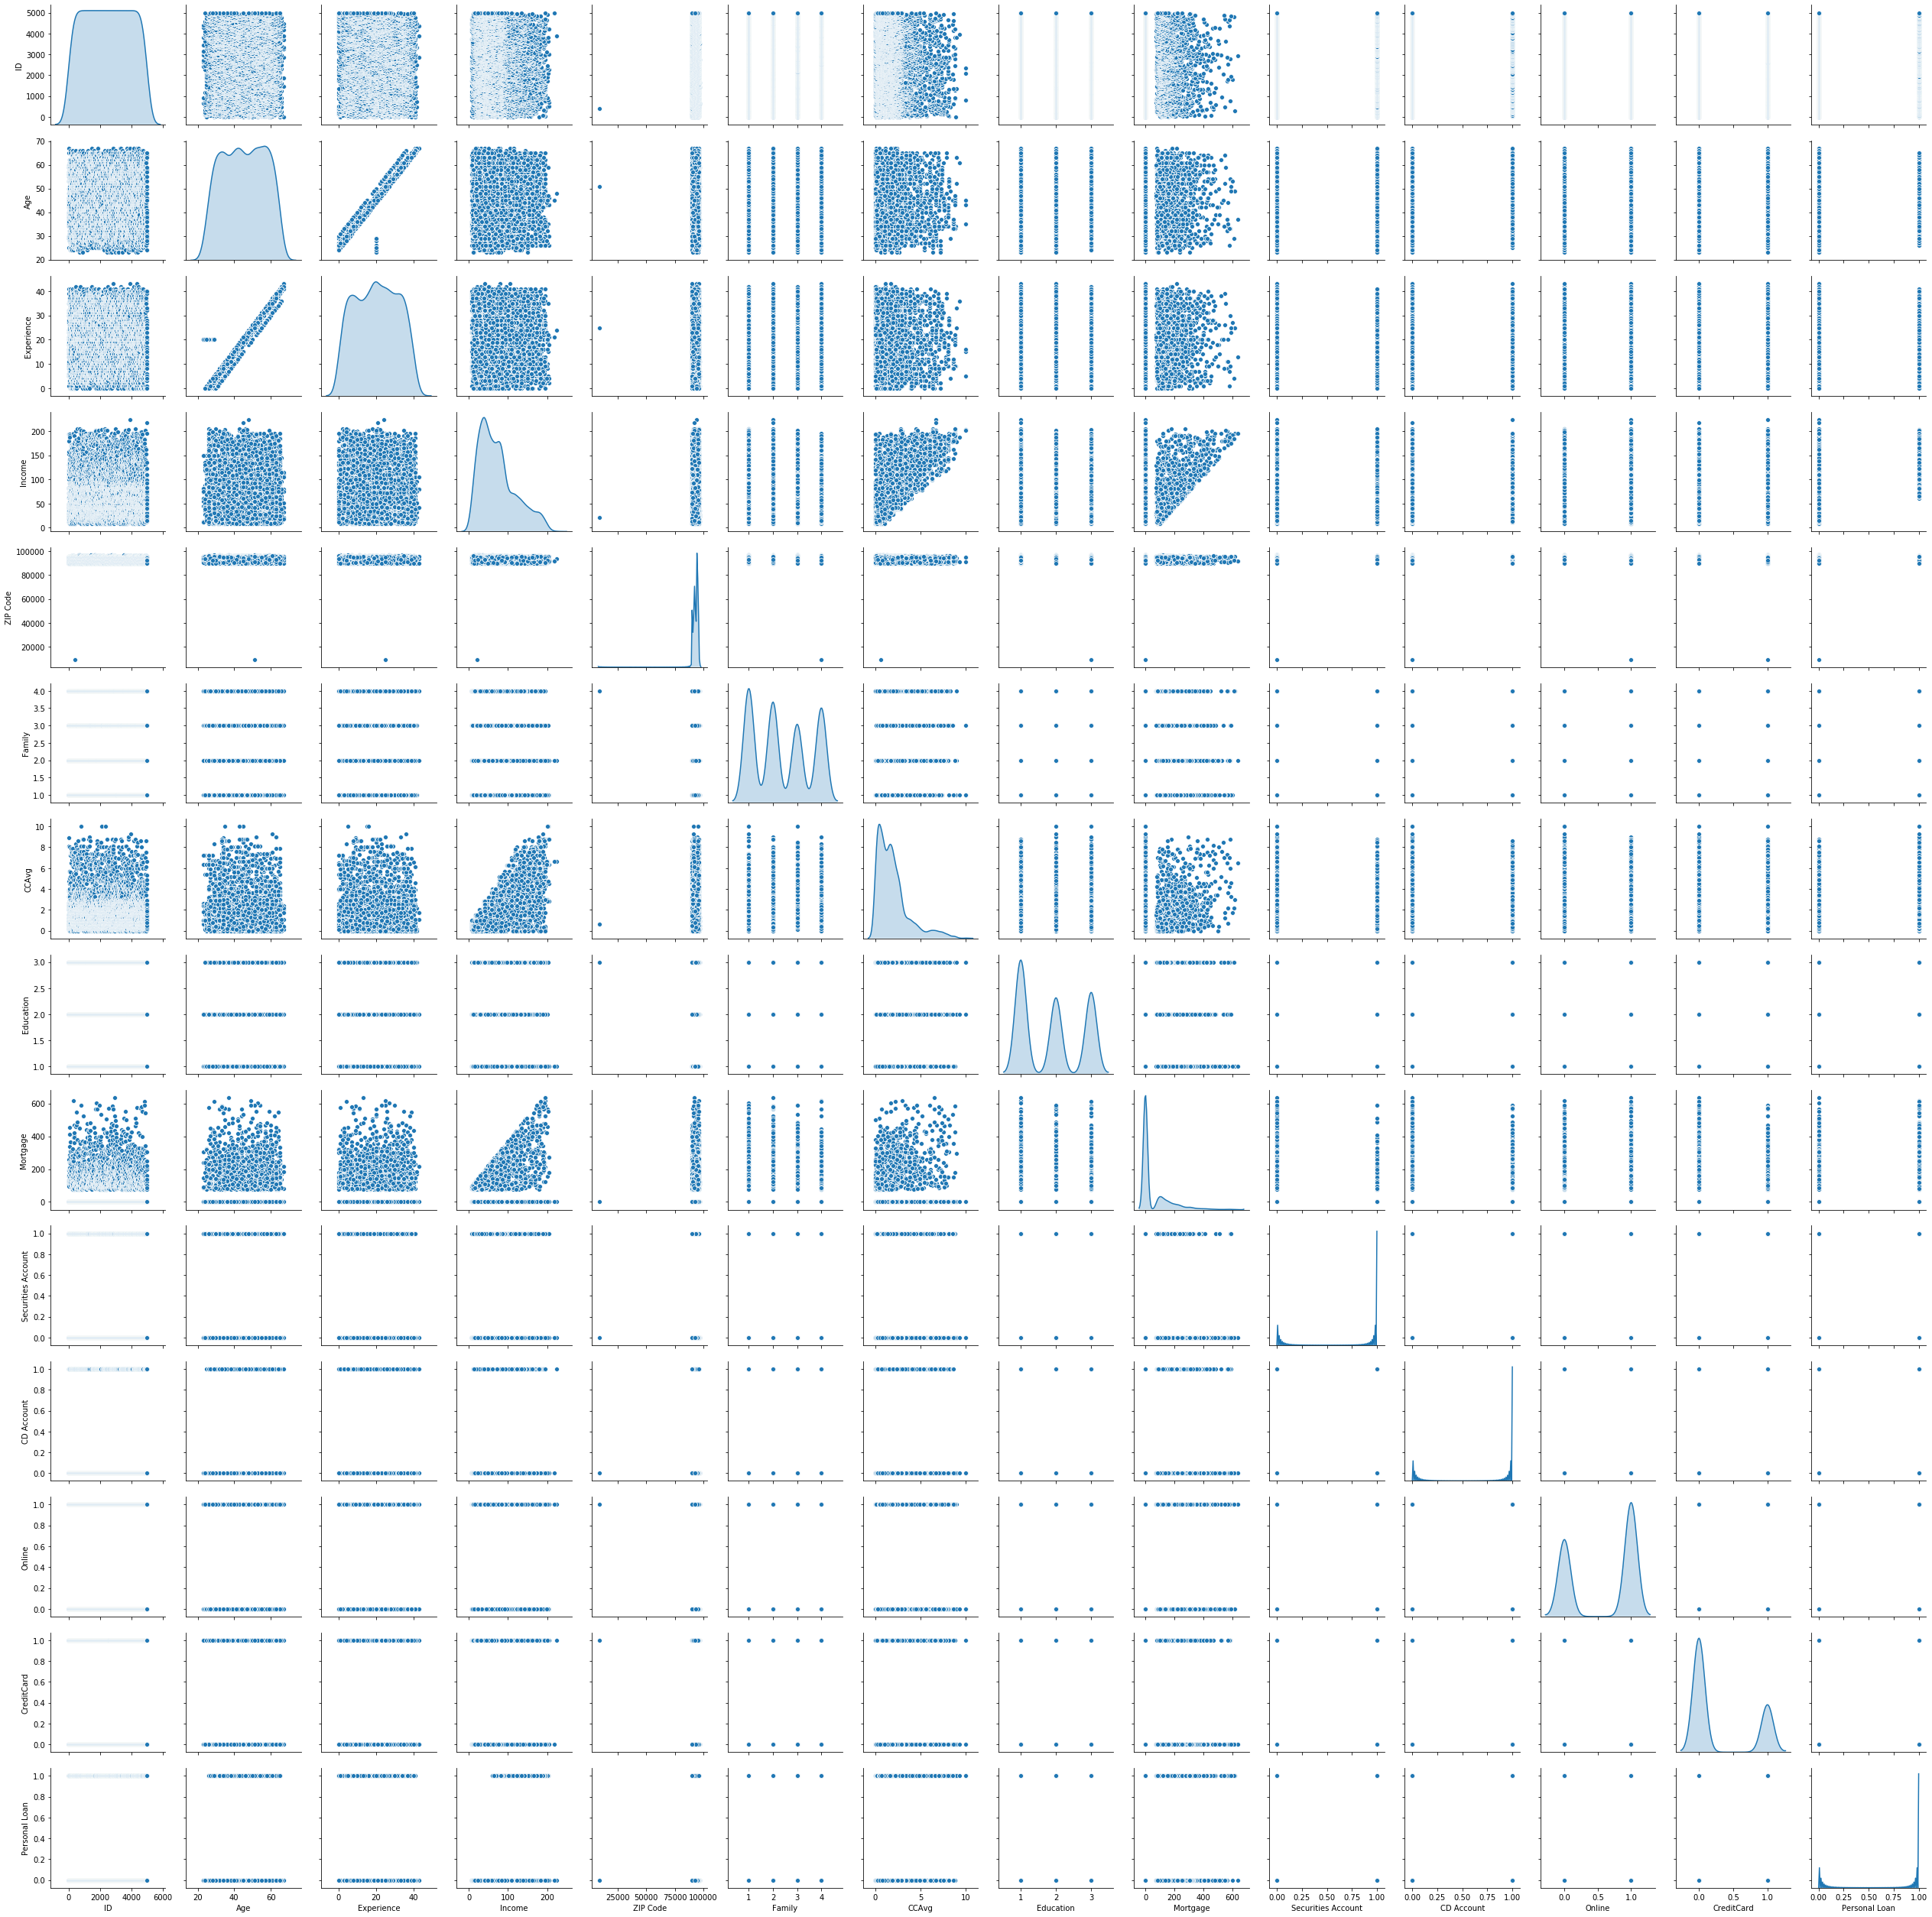

In [11]:
plt.figure(figsize = (8, 20))
sns.pairplot(data =df_bank, diag_kind ='kde')

## The following inferences can be drawn from above plots:


- **ID**: This attribute can be dropped.Though the data distribution is normal.


- **Age**: Three small peaks can be indicating three values of age would be slightly more in number.However, the mean and median
    of the attribute is equal.The distribution is in considerable shape.


- **Eductaion**: Mean and median is almost equal. Data is finely distributed. A few peaks shows different values dominance.
 
 
- **Income**: We can clearly see data is highly left skewed.Data for less income customers is more in the sample.
  
  
- **ZIP Code**: The attribute has sharp peaks telling the data from particular places are collected more.Spread is also less in the sample. More data from different places can be collected.
   
   
- **Family**: It has 4 peaks(4 values) , families with least member is highest in the sample.
    
    
- **Mortage**: This attribute is highly left skewed with a very high peak on the left telling us that most customer are having least mortage while a very few have some mortage.
    
    
- **Securities Account**: This attributes tells us that majorly cutomers are not having Security account.
    
    
- **CD account**: Most of the customers dont have CDaccounts.
    
    
- **Online**: Higher number of customers use online banking in the sample.
    
    
- **Credit Card**: This attribute has less customers using CC in comparison to the CC users.


###### Relationship between the attributes:

- Experience and age are in linear relationship. One can be dropped among them will not effect the accuracy.

In [12]:
corr = df_bank.corr()

In [13]:
mask = np.triu(np.ones_like(corr, dtype = np.bool))

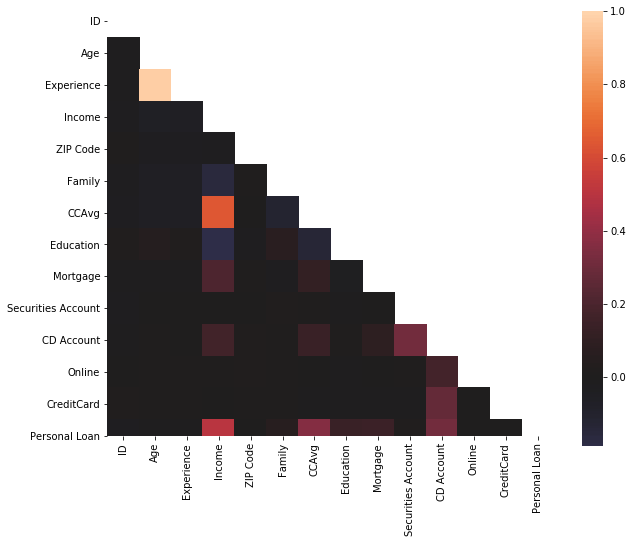

In [14]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr, mask = mask, center = 0, square = True)

###### Correlation between variables

- *Experience* and *Age* have very high positive correlation. It reienforces the dropping of one variable.


- *Personal Loan* has high correlation with *Income*, *CCAvg*, *CD Account* and it has moderate correlation with<br> *Education* and *Mortgage*.

In [15]:
df_bank.groupby(df_bank['Personal Loan']).mean()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
Personal Loan,,,,,,,,,,,,,
0,2512.165487,45.367257,20.378982,66.237389,93152.428761,2.373451,1.728982,1.843584,51.789381,0.102212,0.035841,0.595796,0.293584
1,2390.650000,45.066667,19.843750,144.745833,93153.202083,2.612500,3.905347,2.233333,100.845833,0.125000,0.291667,0.606250,0.297917



- The average Income of customers who took loan is more than double of the avg income of customers who didn’t take loan last year.


- The Average spending on credit cards per month is also more than double for the customer's who took loan.


- The average mortage for loan availing customers is approximately double for the not availing customers.


- Avg literacy is less for non loan takers.

### Relationship of Categorical Variables and Target Variable

In [16]:
def make_bar_graphs(col = None):
    
    '''Function to make barcharts to represent the effect of Personal Loan on different categories of col.'''
    
    if col not in df_bank.columns:
        raise KeyError('Column not in dataframe.')
        
    title = col + ' vs Personal Loan'    
    
    tbl = pd.crosstab(df_bank[col], df_bank['Personal Loan'])
    
    fig, ax = plt.subplots(figsize = (8, 6))
    tbl.div(tbl.sum(axis= 1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, ax = ax)
    ax.legend(loc = 3, title = 'Personal Loan')
    ax.set_title(title, fontsize = 20)
    
    return None

### Do people with higher education have high chance of buying personal loan?

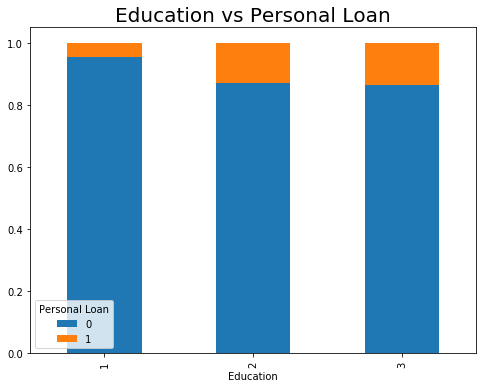

In [17]:
make_bar_graphs(col = 'Education')

- It is clear that higher education leads to a better chance of buying of personal loan.

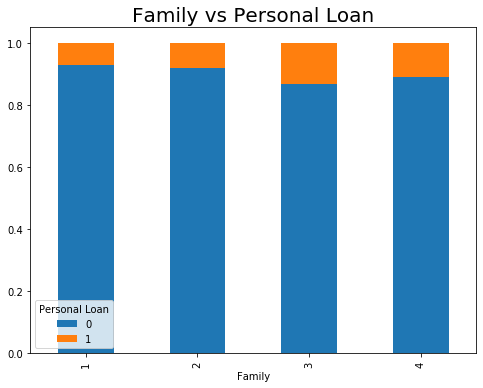

In [18]:
make_bar_graphs(col = 'Family')

- Number of Family Memebers does not have significant effect on the probability of buying personal loan.

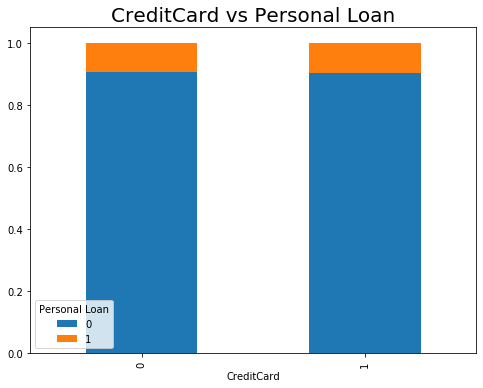

In [19]:
make_bar_graphs(col = 'CreditCard')

- The posession of Credit Card has almost no effect on the probability of buying a **Personal Loan**.

### Does having a CD Account increases the chance of buying a Personal Loan?

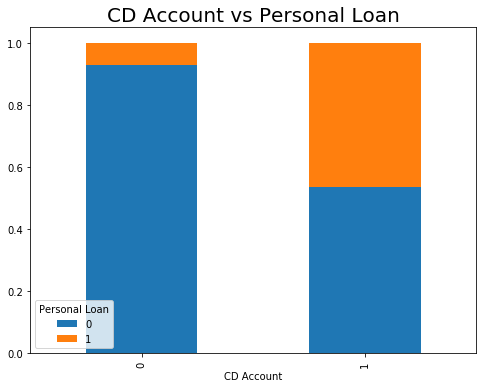

In [20]:
make_bar_graphs('CD Account')

- Customers having a *CD Account* are more likely to buy a **Personal Loan** than customers who do not posses a CD Account.

### Relationship of Numerical Variables with Target Variable

In [21]:
def numeric_graph(col = None):
    
    '''Plots the relationship between col and Personal Loan column of dataframe'''
    
    if col not in df_bank.columns:
        raise KeyError('Column not in Dataframe.')
        
    title = col + ' vs Personal Loan'
    
    fig, ax = plt.subplots(figsize = (8, 6))
    df_bank.groupby('Personal Loan')[col].mean().plot(kind = 'bar', ax = ax)
    ax.set_title(title, fontsize = 20)
    plt.show()
    
    return None

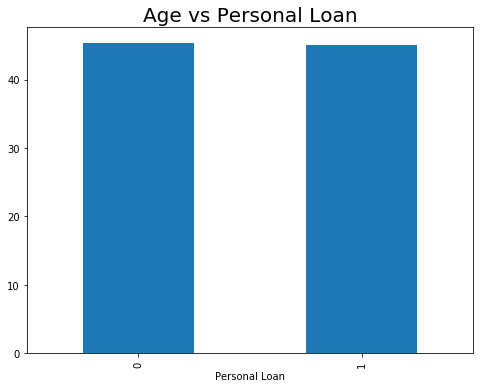

In [22]:
numeric_graph(col = 'Age')

- As we can see that the probability of buying a **Personal Loan** is unaffected by by *Age* variable.

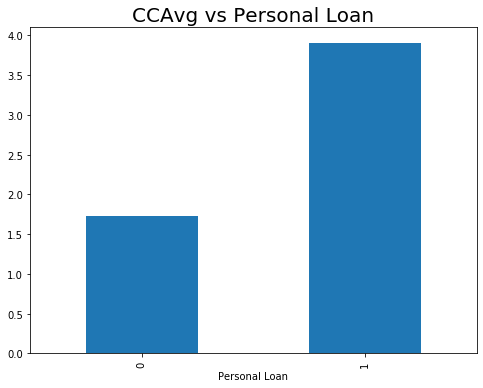

In [23]:
numeric_graph(col = 'CCAvg')

- From the above plot it is clear that customer having higher *Average Credit Card Spendings* are more likely to buy a **Personal Loan**.

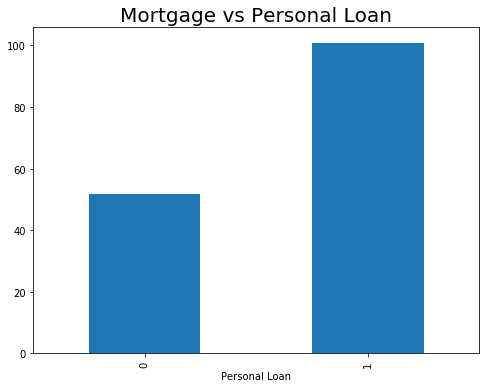

In [24]:
numeric_graph(col = 'Mortgage')

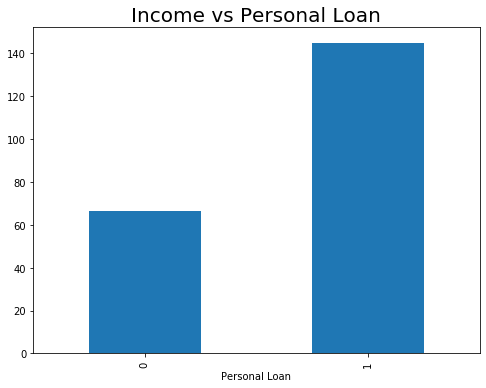

In [25]:
numeric_graph(col = 'Income')

- Both higher *Income* and higher *Mortgage* leads to a higher probability of buying a **Personal Loan**

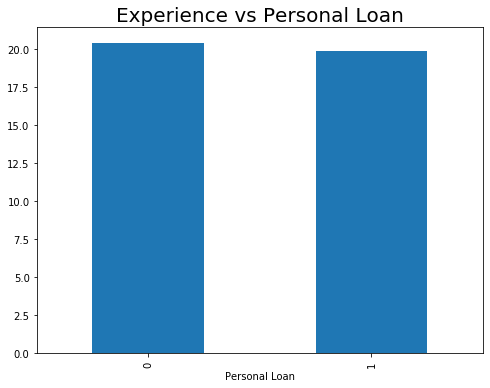

In [26]:
numeric_graph(col = 'Experience')

> The results were expected as *Age* and *Experience* are strongly correlated.

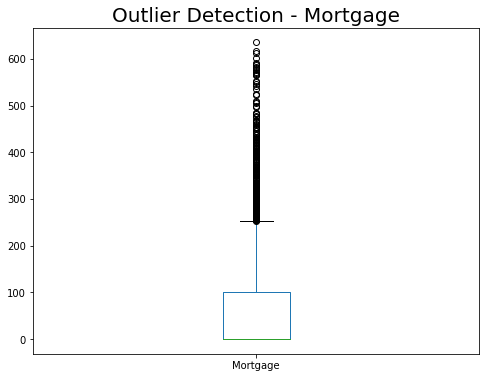

In [27]:
df_bank.plot(y = 'Mortgage', kind = 'box', figsize = (8, 6))
plt.title('Outlier Detection - Mortgage', fontsize = 20)
plt.show()

We can see that Mortgage has a **heavy right-skewness**. It means that it can contain outliers. 

#### Outlier Removal from Mortgage Column

- We can remove the outliers from *Mortgage* column by the method of **Z-Scores**. <font size = 5>$$Z = \frac{X - \bar X }{S}$$

<font size = 5>$$\text {where Z is the standard score} \\ \text{S = the standard deviation of a sample} \\ \text{X = each value in the dataset} \\ \bar X\text{= mean of all values in the dataset}$$

In [28]:
from scipy import stats

In [29]:
df_bank['Mortgage_z'] = np.abs(stats.zscore(df_bank['Mortgage']))
df_bank = df_bank[df_bank['Mortgage_z'] < 3]

In [30]:
df_bank.drop('Mortgage_z', axis = 1, inplace = True)

In [31]:
df_bank.shape

(4895, 14)

In [33]:
df_bank.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online',
       'CreditCard', 'Personal Loan'],
      dtype='object')

#### Now we have to delete columns that are not useful

- *ID* and *ZIP Code* have no relation with the Target Variable.
- *Experience* and *Age* have strong positive correlation.
- So, we can drop the above mentioned columns.

In [34]:
df_bank.drop(['ID', 'ZIP Code', 'Experience'], axis = 1, inplace = True)

In [35]:
df_bank.shape

(4895, 11)

### Standardization and Formation of Train and Test Set

In [47]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.base import clone

In [38]:
X, y = df_bank.drop('Personal Loan', axis = 1), df_bank['Personal Loan']
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42, 
                                                    test_size = 0.3, stratify = df_bank['Personal Loan'])

In [43]:
X_train.shape

(3426, 10)

In [44]:
X_test.shape

(1469, 10)

In [101]:
def model_selection(model, X_train, y_train, X_test, y_test):
    '''Train the model on given dataset and obtain evaluation metrics and plot the auc roc curve.
    '''
    
    clf = clone(model)
    _ = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    print('Accuracy of ' + clf.__class__.__name__ + ' on test set is {:.2f}', accuracy_score(y_test, y_pred))
    
    if hasattr(clf, 'oob_score'):
        y_proba = clf.oob_score(X_test)
    else:
        y_proba = clf.predict_proba(X_test)
        
    print('AUC Score is {:.2f}', roc_auc_score(y_test, y_proba[:, 1]))
    
    return clf

In [102]:
logreg = LogisticRegression()

In [103]:
logreg_model = model_selection(logreg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1339
           1       0.84      0.58      0.69       130

    accuracy                           0.95      1469
   macro avg       0.90      0.79      0.83      1469
weighted avg       0.95      0.95      0.95      1469

Accuracy of LogisticRegression on test set is {:.2f} 0.9530292716133424
AUC Score is {:.2f} 0.9523410122364565


#### Bayesian Model

In [104]:
from sklearn.naive_bayes import GaussianNB
naive_B = GaussianNB()

In [105]:
naive_B_model = model_selection(naive_B, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1339
           1       0.39      0.53      0.45       130

    accuracy                           0.88      1469
   macro avg       0.67      0.73      0.69      1469
weighted avg       0.90      0.88      0.89      1469

Accuracy of GaussianNB on test set is {:.2f} 0.8849557522123894
AUC Score is {:.2f} 0.9207445280634228


- *Accuracy* and *AUC Score* of Bayesian Model is lower than **Logistic Regression**.

#### Decision Trees

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dec_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, min_samples_leaf = 7, random_state = 42)

In [107]:
dec_tree_model = model_selection(dec_tree, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1339
           1       0.93      0.88      0.90       130

    accuracy                           0.98      1469
   macro avg       0.96      0.94      0.95      1469
weighted avg       0.98      0.98      0.98      1469

Accuracy of DecisionTreeClassifier on test set is {:.2f} 0.9836623553437712
AUC Score is {:.2f} 0.9875050267133912


- **Decision Trees** have by far been the most succesful classifier with and accuracy score of $98$ % and <br> *AUC Score* of $99$ %.

### Visualization of Decision Tree

In [90]:
import graphviz

In [99]:
dot_data = tree.export_graphviz(dec_tree_model, feature_names = X.columns, class_names = ['0', '1'], 
                                filled = True, rounded = True, special_characters = True) 
graph = graphviz.Source(dot_data) 

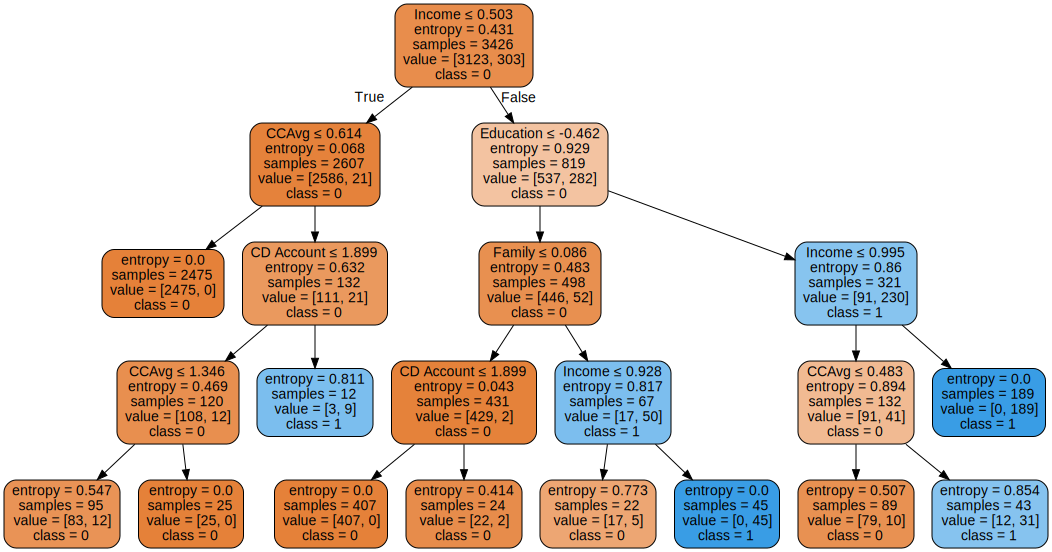

In [100]:
graph

****************************

# Inferences:

- The Data is not perfectly linear as accuracy in case of **Logistic Regression** is less than other classifiers.


- The accuracy of Bayesian Model is low which means the actual probability of obtaining the target class is low.


- *Decision Tree* has by far given maximum accuracy in test and train set.


- The graphical representation of *Decision Tree* can give insights about the classification method

## Save the Model

In [108]:
import pickle

In [109]:
filename = 'final_model.sav'

In [111]:
with open(filename, 'wb') as fout:
    pickle.dump(dec_tree_model, fout)